<a href="https://colab.research.google.com/github/alessandropequeno/PPGEEC-Deep-Learning-UFRN/blob/main/Quest%C3%A3o_1_b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1) Considere o problema das espirais. Sendo a espiral 1 uma classe e a espiral 2 outra classe. Gere os dados usando as seguintes equações: para espiral 1: x = Θ/4 cosΘ :. y = Θ/4 senΘ :. Θ ≥ 0

para espiral 2: x = (Θ/4 + 0.8) cosΘ :. y = (Θ/4 + 0.8) senΘ :. Θ ≥ 0

fazendo Θ assumir 1000 valores igualmente espaçados entre 0 e 20 radianos. Solucione este problema considerando:

b) Um comitê de máquina formado por uma rede perceptron de uma camada oculta, uma
RBF e uma máquina de vetor de suporte (SVM)

### Implementando as Bibliotecas

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics.pairwise import euclidean_distances
import torch
import torch.nn as nn
import torch.optim as optim

### gerando os dados

In [14]:
# Gerar dados em espiral
theta = np.linspace(0, 20, 1000)
X_spiral1 = np.column_stack([theta / 4 * np.cos(theta), theta / 4 * np.sin(theta)])
X_spiral2 = np.column_stack([((theta / 4) + 0.8) * np.cos(theta), ((theta / 4) + 0.8) * np.sin(theta)])
X = np.vstack([X_spiral1, X_spiral2])
y = np.hstack([np.zeros(len(X_spiral1)), np.ones(len(X_spiral2))])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### Classe RBF

In [15]:
class RBFNet(BaseEstimator, ClassifierMixin):
    def __init__(self, num_centers=10, gamma=1.0):
        self.num_centers = num_centers
        self.gamma = gamma

    def fit(self, X, y):
        kmeans = KMeans(n_clusters=self.num_centers, random_state=42)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_
        distances = euclidean_distances(X, self.centers)
        self.std_dev = np.std(distances)
        phi = np.exp(-self.gamma * (distances / self.std_dev) ** 2)
        self.weights = np.linalg.lstsq(phi, y, rcond=None)[0]

    def predict(self, X):
        distances = euclidean_distances(X, self.centers)
        phi = np.exp(-self.gamma * (distances / self.std_dev) ** 2)
        return np.dot(phi, self.weights)

param_grid_rbf = {
    'num_centers': [5, 10, 15, 20],
    'gamma': [0.1, 0.5, 1.0, 2.0, 5.0]
}

rbf_model = RBFNet()
grid_search_rbf = GridSearchCV(rbf_model, param_grid_rbf, cv=5)
grid_search_rbf.fit(X_train, y_train)

print("Best parameters for RBF Network:", grid_search_rbf.best_params_)
best_rbf_model = grid_search_rbf.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 668, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/uti

Best parameters for RBF Network: {'gamma': 0.1, 'num_centers': 5}


### SVM

In [16]:
# Implementar a Máquina de Vetor de Suporte (SVM)
param_grid_svm = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': [0.001, 0.01, 0.1, 1]
}

svm_model = make_pipeline(StandardScaler(), SVC(kernel='rbf'))
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=5)
grid_search_svm.fit(X_train, y_train)

print("Best parameters for SVM:", grid_search_svm.best_params_)
best_svm_model = grid_search_svm.best_estimator_

Best parameters for SVM: {'svc__C': 100, 'svc__gamma': 1}


### Criar a Rede Perceptron

Epoch 0: Loss 0.691969633102417
Epoch 100: Loss 0.6202744245529175
Epoch 200: Loss 0.5305225849151611
Epoch 300: Loss 0.4786244332790375
Epoch 400: Loss 0.449624240398407
Epoch 500: Loss 0.4296024441719055
Epoch 600: Loss 0.4175199270248413
Epoch 700: Loss 0.40626147389411926
Epoch 800: Loss 0.3991236984729767
Epoch 900: Loss 0.3919193744659424


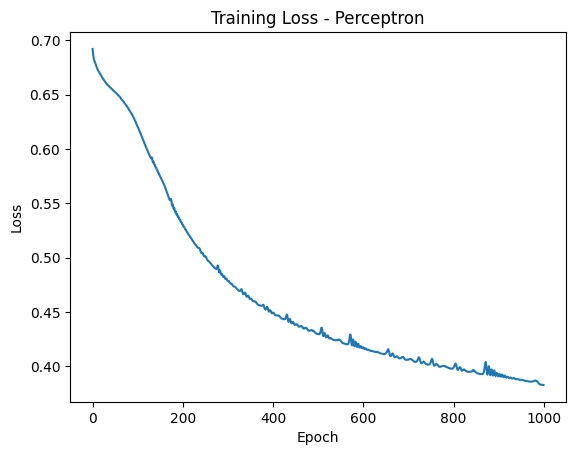

In [17]:
class Perceptron(nn.Module):
    def __init__(self):
        super(Perceptron, self).__init__()
        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 1)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.activation(self.fc3(x))
        return x

    def fit(self, X, y, epochs=1000, lr=0.01):
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)

        X_torch = torch.tensor(X, dtype=torch.float32)
        y_torch = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

        train_losses = []

        for epoch in range(epochs):
            optimizer.zero_grad()
            outputs = self(X_torch)
            loss = criterion(outputs, y_torch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            if epoch % 100 == 0:
                print(f"Epoch {epoch}: Loss {loss.item()}")

        plt.plot(train_losses)
        plt.title("Training Loss - Perceptron")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

    def predict(self, X):
        X_torch = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            outputs = self(X_torch)
        return outputs.numpy().flatten()

perceptron_model = Perceptron()
perceptron_model.fit(X_train, y_train)

### Avaliação dos modelos

In [18]:
# Avaliar o desempenho de cada modelo
y_pred_rbf = best_rbf_model.predict(X_test)
y_pred_perceptron = perceptron_model.predict(X_test)
y_pred_svm = best_svm_model.predict(X_test)

print("Accuracy - RBF Network:", accuracy_score(y_test, y_pred_rbf.round().astype(int)))
print("Accuracy - Perceptron:", accuracy_score(y_test, y_pred_perceptron.round().astype(int)))
print("Accuracy - SVM:", accuracy_score(y_test, y_pred_svm.round().astype(int)))

Accuracy - RBF Network: 0.6925
Accuracy - Perceptron: 0.73
Accuracy - SVM: 0.7825


### Classe Comite de Máquinas

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch 0: Loss 0.38308319449424744
Epoch 100: Loss 0.37921199202537537
Epoch 200: Loss 0.3762505054473877
Epoch 300: Loss 0.3731810450553894
Epoch 400: Loss 0.36884820461273193
Epoch 500: Loss 0.36404499411582947
Epoch 600: Loss 0.3592296540737152
Epoch 700: Loss 0.35362547636032104
Epoch 800: Loss 0.347208172082901
Epoch 900: Loss 0.3394945561885834


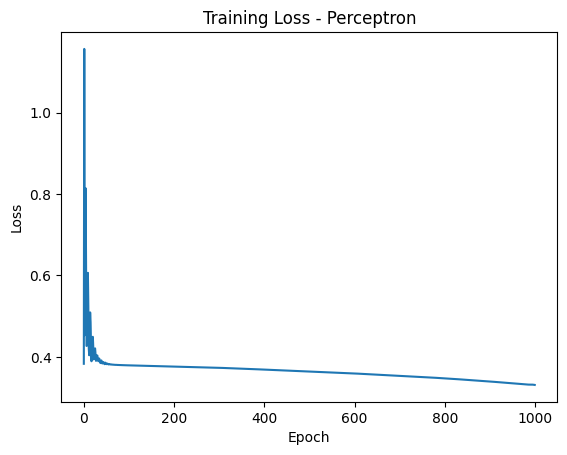

Accuracy - Committee: 0.8


In [19]:
class CommitteeClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        for model in self.models:
            if hasattr(model, "fit"):
                model.fit(X, y)

    def predict(self, X):
        predictions = np.zeros((X.shape[0], len(self.models)))
        for idx, model in enumerate(self.models):
            predictions[:, idx] = model.predict(X)
        return np.mean(predictions, axis=1)

committee_models = [best_rbf_model, perceptron_model, best_svm_model]
committee = CommitteeClassifier(models=committee_models)
committee.fit(X_train, y_train)

y_pred_committee = committee.predict(X_test)
print("Accuracy - Committee:", accuracy_score(y_test, y_pred_committee.round().astype(int)))



### Visualização as previsões no conjunto de pontos

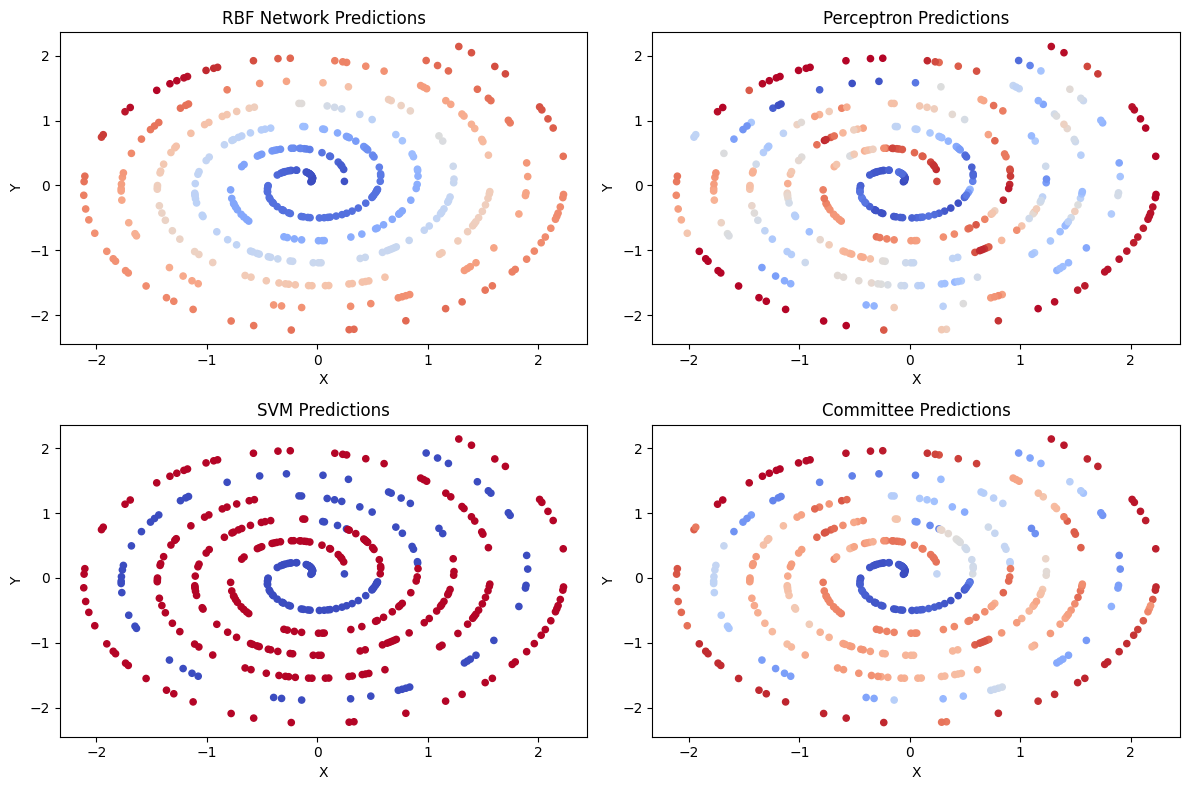

In [21]:
# Plotar os resultados de cada modelo
plt.figure(figsize=(12, 8))

# Plotar as previsões da RBF Network
plt.subplot(2, 2, 1)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_rbf, cmap=plt.cm.coolwarm, s=20)
plt.title("RBF Network Predictions")
plt.xlabel("X")
plt.ylabel("Y")

# Plotar as previsões do Perceptron
plt.subplot(2, 2, 2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_perceptron, cmap=plt.cm.coolwarm, s=20)
plt.title("Perceptron Predictions")
plt.xlabel("X")
plt.ylabel("Y")

# Plotar as previsões do SVM
plt.subplot(2, 2, 3)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_svm, cmap=plt.cm.coolwarm, s=20)
plt.title("SVM Predictions")
plt.xlabel("X")
plt.ylabel("Y")

# Plotar as previsões do comitê
plt.subplot(2, 2, 4)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_committee, cmap=plt.cm.coolwarm, s=20)
plt.title("Committee Predictions")
plt.xlabel("X")
plt.ylabel("Y")

plt.tight_layout()
plt.show()



### Gerar a matrix de confusão

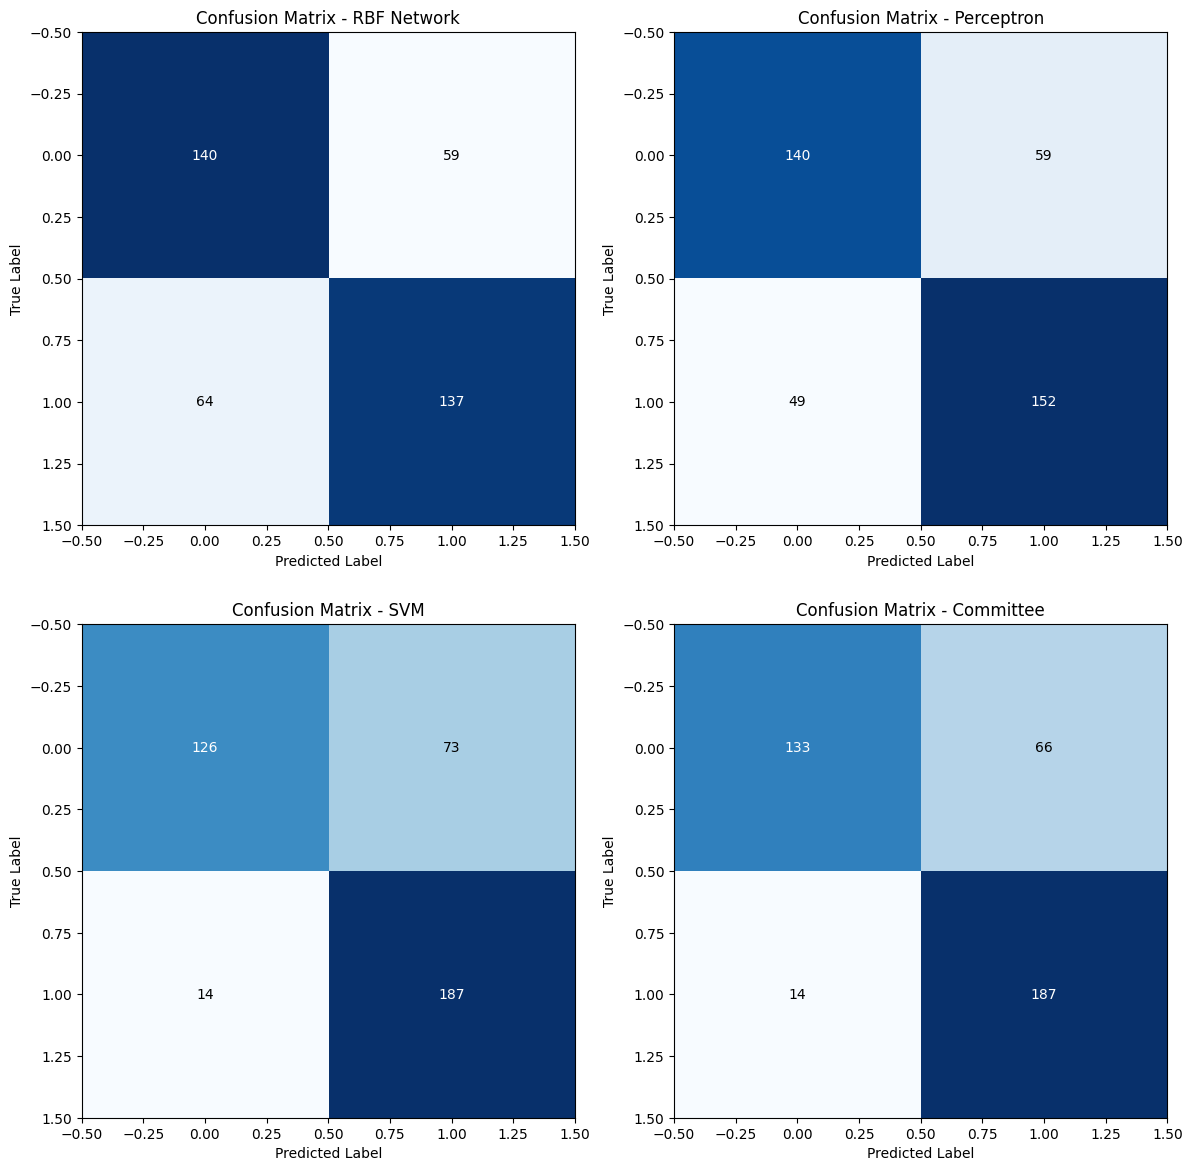

In [23]:
# Calcular e plotar as matrizes de confusão
cm_rbf = confusion_matrix(y_test, y_pred_rbf.round().astype(int))
cm_perceptron = confusion_matrix(y_test, y_pred_perceptron.round().astype(int))
cm_svm = confusion_matrix(y_test, y_pred_svm.round().astype(int))
cm_committee = confusion_matrix(y_test, y_pred_committee.round().astype(int))

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Função para adicionar os valores dentro das células
def annotate_confusion_matrix(matrix, ax):
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            ax.text(j, i, format(matrix[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if matrix[i, j] > matrix.max() / 2 else "black")

# Plotando cada matriz de confusão com os valores
axs[0, 0].imshow(cm_rbf, interpolation='nearest', cmap=plt.cm.Blues)
axs[0, 0].set_title('Confusion Matrix - RBF Network')
axs[0, 0].set_xlabel('Predicted Label')
axs[0, 0].set_ylabel('True Label')
annotate_confusion_matrix(cm_rbf, axs[0, 0])

axs[0, 1].imshow(cm_perceptron, interpolation='nearest', cmap=plt.cm.Blues)
axs[0, 1].set_title('Confusion Matrix - Perceptron')
axs[0, 1].set_xlabel('Predicted Label')
axs[0, 1].set_ylabel('True Label')
annotate_confusion_matrix(cm_perceptron, axs[0, 1])

axs[1, 0].imshow(cm_svm, interpolation='nearest', cmap=plt.cm.Blues)
axs[1, 0].set_title('Confusion Matrix - SVM')
axs[1, 0].set_xlabel('Predicted Label')
axs[1, 0].set_ylabel('True Label')
annotate_confusion_matrix(cm_svm, axs[1, 0])

axs[1, 1].imshow(cm_committee, interpolation='nearest', cmap=plt.cm.Blues)
axs[1, 1].set_title('Confusion Matrix - Committee')
axs[1, 1].set_xlabel('Predicted Label')
axs[1, 1].set_ylabel('True Label')
annotate_confusion_matrix(cm_committee, axs[1, 1])

plt.tight_layout()
plt.show()
